# Previous notebook was getting chaotic, new one with everything already cleaned

In [613]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import os
import re
import pickle
from IPython.display import clear_output
from scipy.stats import linregress
from scipy.spatial.distance import euclidean, pdist, squareform
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram

In [2]:
funded_R01_projects = pd.DataFrame()
for root, dirs, files in os.walk("data/funded_R01_projects_category_dfs/cleaned/", topdown=True):
    for file in files:
        df = pd.read_csv(os.path.join(root, file))
        funded_R01_projects = funded_R01_projects.append(df)

/Users/maheshrao/anaconda3/envs/capstone/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,11,12,15,19,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/maheshrao/anaconda3/envs/capstone/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,11,12,15,17,19,24,26,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
nih_budget = pd.read_csv("data/nih_budget_full.csv")
brdpi = pd.read_excel("data/BRDPI Table FY 1950 to 2023_Jan 2018_Rev.xlsx", skiprows = [0, 1, 2], skip_footer = 10)
inflation = pd.read_excel("data/SeriesReport-20180718142529_be797a.xlsx", skiprows=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12])

/Users/maheshrao/anaconda3/envs/capstone/lib/python3.6/site-packages/pandas/util/_decorators.py:178: FutureWarning: the 'skip_footer' keyword is deprecated, use 'skipfooter' instead
  return func(*args, **kwargs)


In [107]:
nih_budget_actual_percentages = [100]
counter = 1
annual_budgets = nih_budget.loc[nih_budget.FY >= 1950].Total.tolist()
l = len(annual_budgets)-1
while counter <= l:
    pct_inc = annual_budgets[counter]/annual_budgets[counter-1]
    overall_pct_inc = pct_inc + nih_budget_actual_percentages[-1]
    nih_budget_actual_percentages.append(overall_pct_inc)
    counter += 1

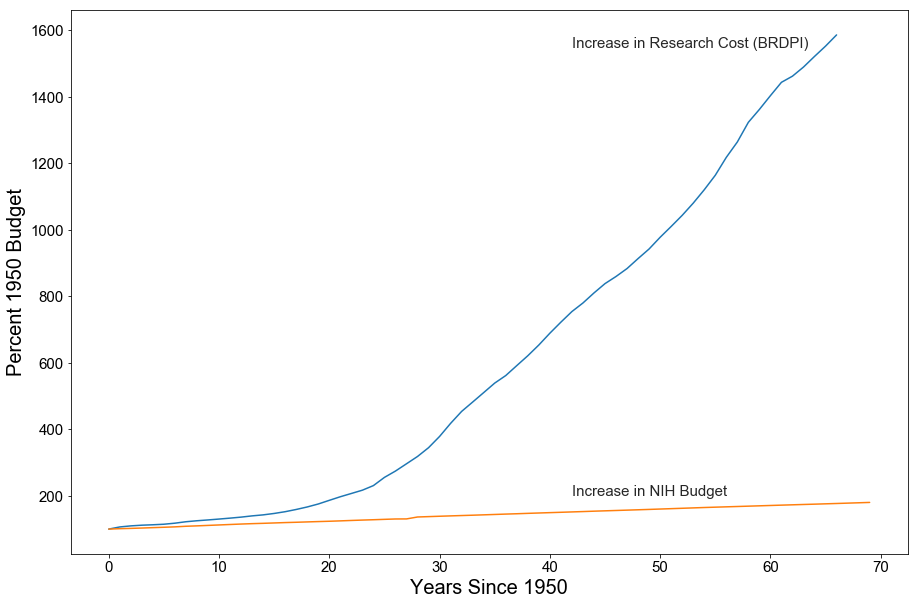

In [5]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.set_style("darkgrid")
plt.plot(brdpi[1950][:-7])
plt.plot(nih_budget_actual_percentages)
plt.xlabel("Years Since 1950", size = 20)
plt.ylabel("Percent 1950 Budget", size = 20)
plt.text(s = "Increase in Research Cost (BRDPI)", x = 42, y = 1550, size = 15)
plt.text(s = "Increase in NIH Budget", x = 42, y = 200, size = 15)
ax.tick_params(axis='both', labelsize = 15)
plt.show();

In [6]:
R01s_per_year = funded_R01_projects.groupby("FY").count()

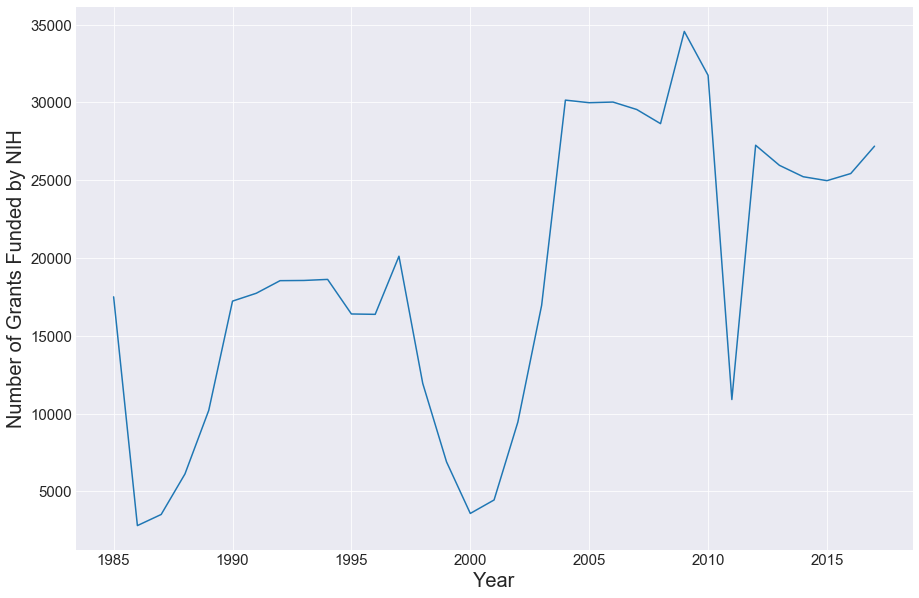

In [7]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.set_style("darkgrid")
plt.plot(R01s_per_year.loc[R01s_per_year.index != 2018.0]["grant_num"])
plt.xlabel("Year", size = 20)
plt.ylabel("Number of Grants Funded by NIH", size = 20)
ax.tick_params(axis='both', labelsize = 15)
plt.show();

In [8]:
years = []
categories = []
for year in np.sort(funded_R01_projects.FY.unique()):
    df_year = funded_R01_projects[funded_R01_projects.FY == year]
    num_categories = len(df_year.category.unique())
    categories.append(num_categories)
    years.append(year)

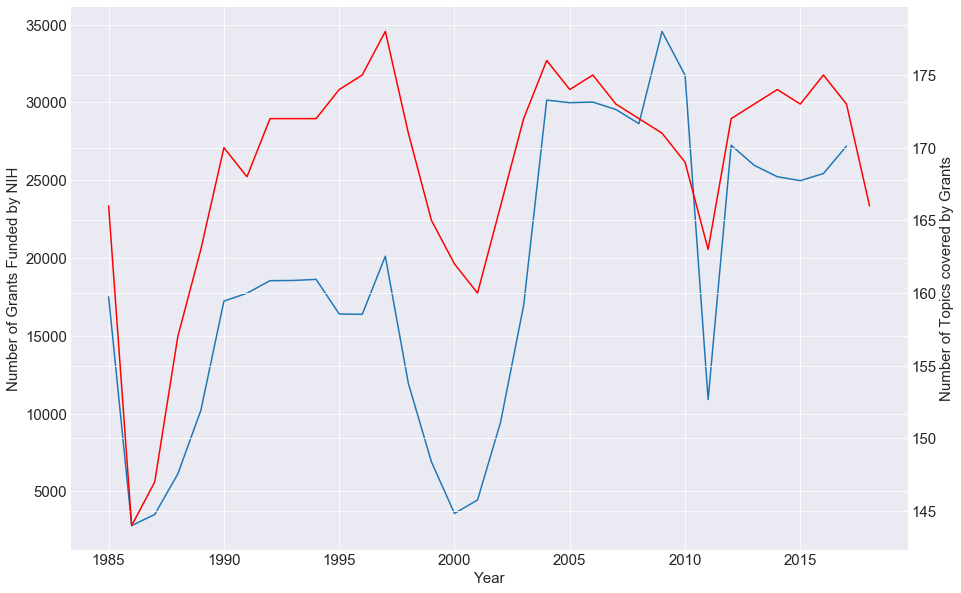

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))
ax2 = ax.twinx()
ax.plot(R01s_per_year.loc[R01s_per_year.index != 2018.0]["grant_num"])
ax2.plot(years, categories, color = "red")
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('Number of Grants Funded by NIH', fontsize = 15)
ax2.set_ylabel('Number of Topics covered by Grants', fontsize = 15)
ax.tick_params(axis='both', labelsize = 15)
ax2.tick_params(labelsize = 15);

In [10]:
nih_budget_1985 = nih_budget[nih_budget.FY >= 1985]
nih_budget_1985.reset_index(drop = True, inplace = True)
nih_budget_1985_totals = nih_budget_1985.Total.tolist()

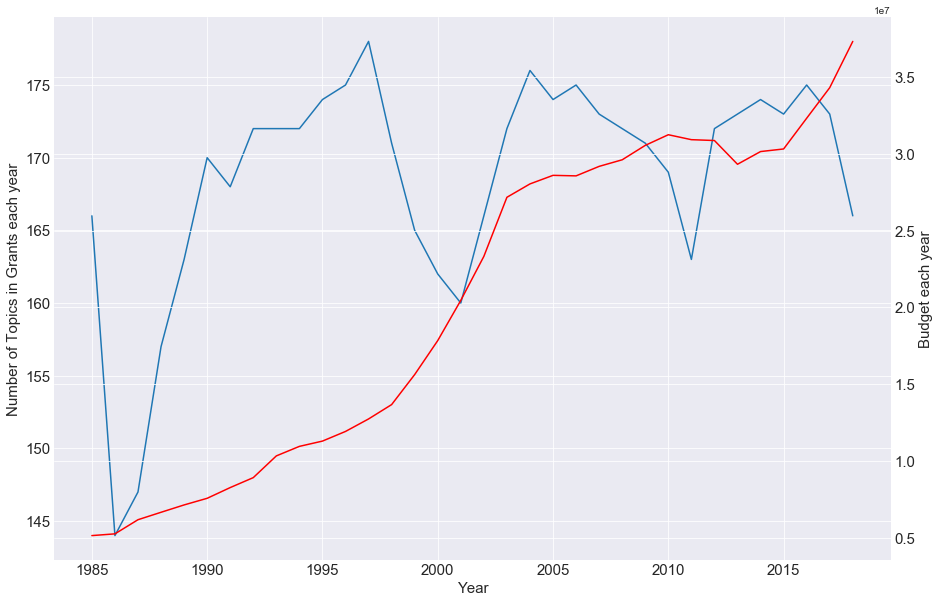

In [11]:
fig, ax = plt.subplots(figsize=(15, 10))
ax2 = ax.twinx()
ax.plot(years, categories)
ax2.plot(years, nih_budget_1985_totals, color = "red")
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('Number of Topics in Grants each year', fontsize = 15)
ax2.set_ylabel('Budget each year', fontsize = 15)
ax.tick_params(axis='both', labelsize = 15)
ax2.tick_params(labelsize = 15);

In [12]:
funded_R01_projects["ic_code"] = funded_R01_projects.grant_num.str.extract(r"([A-Z]{2})")

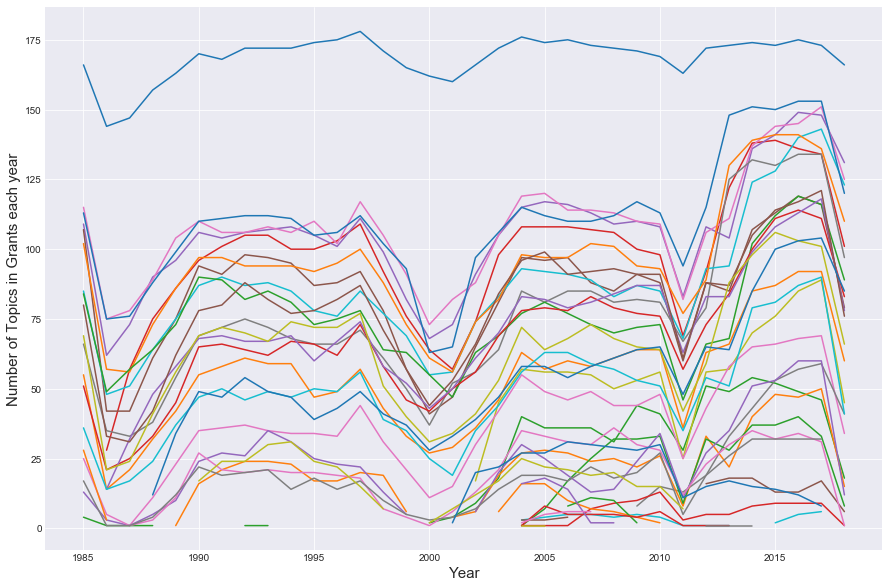

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(years, categories)
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('Number of Topics in Grants each year', fontsize = 15)
for institute in funded_R01_projects["ic_code"].unique():
    df = funded_R01_projects[funded_R01_projects.ic_code == institute]
    funding_years = df.FY.unique()
    categories_institute = []
    for year in years:
        if year in funding_years:
            df_year = df[df.FY == year]
            num_categories = len(df_year.category.unique())
            categories_institute.append(num_categories)
        else:
            categories_institute.append(np.nan)
    ax.plot(years, categories_institute);

In [14]:
inflation_per_year = inflation.Annual.tolist()[:-1]

In [15]:
nih_budget_in_1985 = nih_budget_1985.Total.iloc[0]

In [16]:
projected_budgets = [nih_budget_in_1985]
for i in inflation_per_year:
    projected_budgets.append(projected_budgets[-1] * i)

Text(2005,1e+08,'NIH Budget')

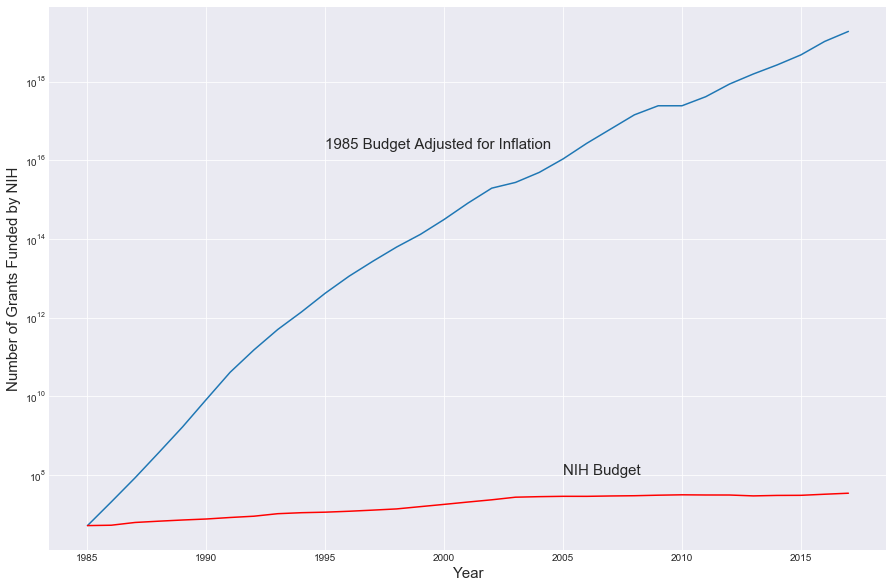

In [37]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(years[:-1], projected_budgets)
plt.plot(years[:-1], nih_budget_1985_totals[:-1], color = "red")
plt.yscale("log")
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Number of Grants Funded by NIH', fontsize = 15)
plt.text(s = "1985 Budget Adjusted for Inflation", x = 1995, y = 10**16.3, size = 15)
plt.text(s = "NIH Budget", x = 2005, y = 10**8, size = 15)
#ax.tick_params(axis='both', labelsize = 15);

In [66]:
#plt.plot(brdpi[1950][:-7])
brdpi["Year"] = brdpi["Year"].astype(str).str.strip().str.replace(r"[pr]","").astype(int)

In [73]:
brdpi_1985 = brdpi[(brdpi.Year >= 1985) & (brdpi.Year <= 2017)][1985].tolist()

Text(2005,205,'Brdpi Projected from 1985')

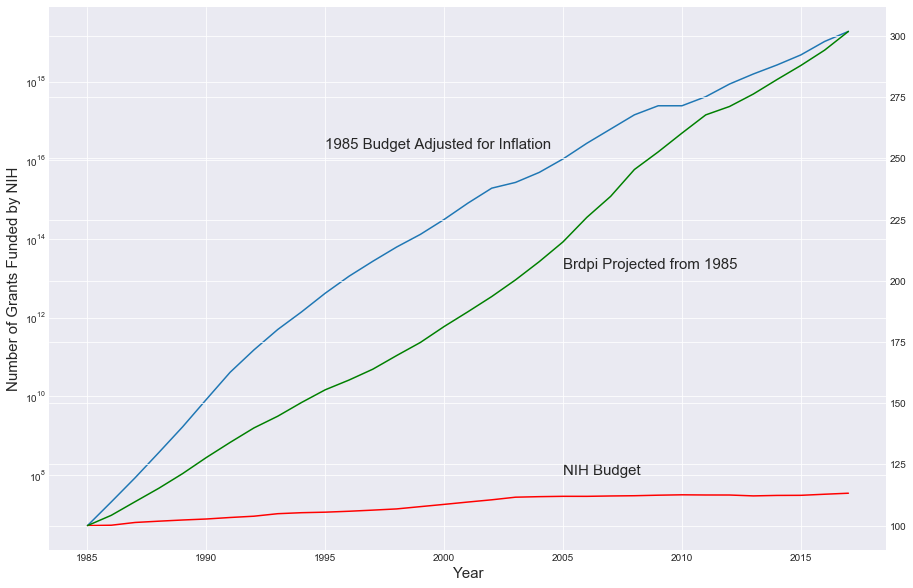

In [88]:
fig, ax = plt.subplots(figsize=(15, 10))
ax2 = ax.twinx()
ax.plot(years[:-1], projected_budgets)
ax.plot(years[:-1], nih_budget_1985_totals[:-1], color = "red")
ax.set_yscale("log")
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('Number of Grants Funded by NIH', fontsize = 15)
ax2.plot(years[:-1], brdpi_1985, color = "green")
ax2.set_ylabel("Brdpi percent increase from 1985")
ax.text(s = "1985 Budget Adjusted for Inflation", x = 1995, y = 10**16.3, size = 15)
ax.text(s = "NIH Budget", x = 2005, y = 10**8, size = 15)
ax2.text(s = "Brdpi Projected from 1985", x = 2005, y = 205, size = 15)
#ax.tick_params(axis='both', labelsize = 15);

In [94]:
# Try to get it on the same scale, percentages may be making it strange

brdpi_1985_dollars = [nih_budget_in_1985 * (pct/100) for pct in brdpi_1985]

Text(2005,1e+08,'NIH Budget')

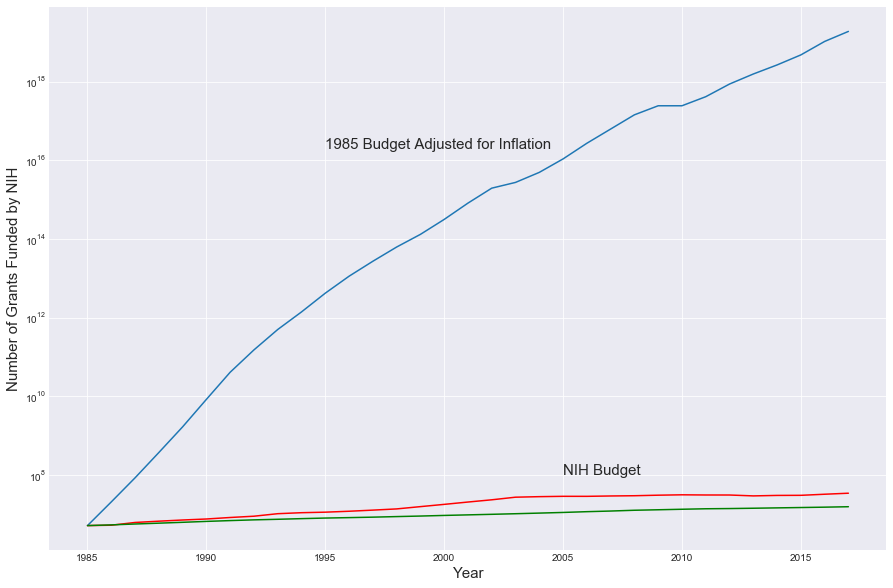

In [98]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(years[:-1], projected_budgets)
plt.plot(years[:-1], nih_budget_1985_totals[:-1], color = "red")
plt.plot(years[:-1], brdpi_1985_dollars, color = "green")
plt.yscale("log")
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Number of Grants Funded by NIH', fontsize = 15)
ax.text(s = "1985 Budget Adjusted for Inflation", x = 1995, y = 10**16.3, size = 15)
ax.text(s = "NIH Budget", x = 2005, y = 10**8, size = 15)

In [100]:
brdpi

,Year,Annual Change,1950,1951,1952,1953,1954,1955,1956,1957,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,1950,NaN,100.000000,93.946261,91.200503,89.512647,88.502592,87.251954,84.903452,81.884876,...,7.555478,7.340579,7.123940,6.925793,6.838196,6.712471,6.571255,6.440260,6.303228,6.143408
1,1951,0.064438,106.443832,100.000000,97.077310,95.280691,94.205550,92.874324,90.374488,87.161400,...,8.042341,7.813594,7.582995,7.582995,7.278838,7.145012,6.994696,6.855260,6.709398,6.539279
2,1952,0.030107,109.648518,103.010683,100.000000,98.149291,97.041781,95.670475,93.095377,89.785553,...,8.284470,8.048836,7.811295,7.811295,7.497981,7.360126,7.205284,7.061650,6.911396,6.736156
3,1953,0.018856,111.716058,104.953059,101.885607,100.000000,98.871607,97.474444,94.850790,91.478555,...,8.440682,8.200606,7.958585,7.958585,7.639363,7.498909,7.341147,7.194805,7.041718,6.863173
4,1954,0.011413,112.991041,106.150858,103.048397,101.141271,100.000000,98.586891,95.933294,92.522573,...,8.537014,8.294197,8.049414,8.049414,7.726549,7.584491,7.424930,7.276917,7.122083,6.941501
5,1955,0.014334,114.610613,107.672386,104.525456,102.590993,101.433364,100.000000,97.308367,93.848758,...,8.659380,8.413083,8.164792,8.164792,7.837298,7.693205,7.531356,7.381222,7.224168,7.040998
6,1956,0.027661,117.780841,110.650696,107.416719,105.428748,104.239097,102.766085,100.000000,96.444695,...,8.898906,8.645796,8.390637,8.390637,8.054085,7.906005,7.739680,7.585393,7.423995,7.235758
7,1957,0.036864,122.122674,114.729686,111.376493,109.315238,108.081732,106.554420,103.686366,100.000000,...,9.226952,8.964512,8.699946,8.699946,8.350988,8.197450,8.024993,7.865018,7.697671,7.502494
8,1958,0.024266,125.086147,117.513758,114.079195,111.967921,110.704483,109.140108,106.202458,102.426637,...,9.450857,9.182048,8.911062,8.911062,8.553636,8.396372,8.219730,8.055874,7.884465,7.684553
9,1959,0.019559,127.532736,119.812237,116.310497,114.157927,112.869777,111.274805,108.279696,104.430023,...,9.635708,9.361642,9.085356,9.085356,8.720939,8.560599,8.380502,8.213440,8.038679,7.834856


In [103]:
list(zip([(pct/100) for pct in brdpi_1985], brdpi_1985_dollars))

[(1.0, 5149459.0),
 (1.0419851016998292, 5365659.5598141),
 (1.0975178925424467, 5651623.389413735),
 (1.1525388615060939, 5934951.613232309),
 (1.2124261646196253, 6243338.825236011),
 (1.2782485763926086, 6582288.635942106),
 (1.3399326563588674, 6899928.276681077),
 (1.3990360555363508, 7204278.807506162),
 (1.4468396371477115, 7450441.391067017),
 (1.502846799501699, 7738847.977315219),
 (1.5549040896462736, 8006914.85856581),
 (1.594692179667836, 8211801.996820155),
 (1.639052282942785, 8440232.52987027),
 (1.6946253934056288, 8726403.983701156),
 (1.748279138111925, 9002691.742262695),
 (1.8134291318405855, 9338178.96381869),
 (1.873720321499333, 9648645.973027634),
 (1.9357819693675404, 9968229.884197405),
 (2.0038263603154047, 10318621.685563404),
 (2.0784813713923587, 10703054.604248723),
 (2.1593435976034883, 11119451.322771661),
 (2.259309304129473, 11634220.629933253),
 (2.34502933597709, 12075632.41941125),
 (2.4547981972626407, 12640882.67007788),
 (2.5266635801322015, 13

In [108]:
nih_budget_actual_percentages_2 = []
annual_budgets = nih_budget.loc[nih_budget.FY >= 1950].Total.tolist()
for i in list(range(len(annual_budgets))):
    pct_inc = (annual_budgets[i]/annual_budgets[0])*100
    nih_budget_actual_percentages_2.append(pct_inc)

In [110]:
nih_budget_actual_percentages_2

[100.0,
 122.84212922563268,
 107.99408126873315,
 111.18488447091855,
 134.3077740258755,
 153.9458208445574,
 186.87445460409,
 337.3221535076071,
 399.17858633380126,
 553.5853852866412,
 757.635542740069,
 1045.3067496300794,
 1404.1924346473422,
 1669.8429259779186,
 1645.424365443715,
 1819.5526805023335,
 2087.716735592063,
 1924.0695071518005,
 2042.0780058428502,
 2105.2414918238037,
 2012.7613157794895,
 2300.806237432181,
 2857.221990363091,
 3343.6373638881514,
 3396.4885988541946,
 3970.2868308229313,
 4367.200364229616,
 832.9988238418637,
 4825.165990059567,
 5393.132754107069,
 6051.477785787457,
 6504.789998861783,
 6771.267594946315,
 6908.743407823348,
 7633.586902910042,
 8524.46788329476,
 9768.67435595857,
 9982.568198201616,
 11729.16113366468,
 12646.911636377434,
 13553.828205030923,
 14372.561368896308,
 15697.421937246272,
 16924.70121789278,
 19607.686762529876,
 20783.440831657623,
 21435.52376977653,
 22626.93402132261,
 24169.751868573814,
 25941.57719012

In [112]:
list(zip(nih_budget_actual_percentages, nih_budget_1985_totals))

[(100, 5149459.0),
 (101.22842129225633, 5262211.0),
 (102.10755031704205, 6182910.0),
 (103.13709641035291, 6666693.0),
 (104.34506433391545, 7144765.0),
 (105.49128108838939, 7576352.0),
 (106.70517863740295, 8274739.0),
 (108.51025228549602, 8921687.0),
 (109.6936272348819, 10335996.0),
 (111.08043856254095, 10955783.0),
 (112.44903600545894, 11299522.0),
 (113.82873203430364, 11927562.0),
 (115.17206253048982, 12740843.0),
 (116.36124635229078, 13674843.0),
 (117.34662308434484, 15629156.0),
 (118.45244886322327, 17840587.0),
 (119.59982797346464, 20458556.0),
 (120.52144223001088, 23321382.0),
 (121.58277499280995, 27166715.0),
 (122.61370597869796, 28036627.0),
 (123.5697774429915, 28594357.0),
 (124.71288677214767, 28560417.0),
 (125.95472189232359, 29178504.0),
 (127.12496255796513, 29607070.0),
 (128.14076906722863, 30545098.0),
 (129.30970772704404, 31238000.0),
 (130.4096787241834, 30916345.0),
 (130.60041850124165, 30860913.0),
 (136.39294287457207, 29315822.0),
 (137.51065

In [115]:
test = [(i/5149459.0)*100 for i in nih_budget_1985_totals]

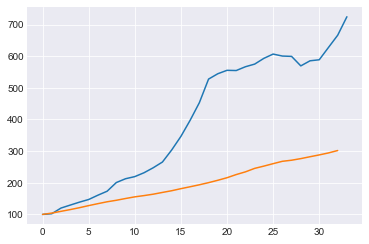

In [117]:
plt.plot(test)
plt.plot(brdpi_1985);

In [120]:
list(zip(brdpi_1985, test))

[(100.0, 100.0),
 (104.19851016998292, 102.18958923646153),
 (109.75178925424467, 120.06911794035062),
 (115.25388615060939, 129.46394951391983),
 (121.24261646196253, 138.74787623321208),
 (127.82485763926086, 147.12908676426008),
 (133.99326563588673, 160.69142408940434),
 (139.9036055536351, 173.25484094542747),
 (144.68396371477115, 200.72003680386618),
 (150.2846799501699, 212.75600019341837),
 (155.49040896462736, 219.43124510749576),
 (159.4692179667836, 231.6274777602851),
 (163.9052282942785, 247.42100092456317),
 (169.46253934056287, 265.55882860704395),
 (174.8279138111925, 303.51064063234605),
 (181.34291318405855, 346.4555597005433),
 (187.3720321499333, 397.29524985051825),
 (193.57819693675404, 452.8899443611455),
 (200.38263603154047, 527.5644490032836),
 (207.8481371392359, 544.457718762301),
 (215.93435976034883, 555.2885652648172),
 (225.93093041294733, 554.6294669012804),
 (234.502933597709, 566.6324171141084),
 (245.47981972626405, 574.9549612881664),
 (252.6663580

# I think I calculated brdpi/percent increase for budget incorrectly, for now, don't include

In [129]:
[funded_R01_projects[funded_R01_projects.FY == year].category.value_counts().head(10).index for year in years]

[Index(['Bioengineering', 'Genetics', 'Infectious Diseases', 'Pediatric',
        'Digestive Diseases', 'Pregnancy', 'Liver Disease', 'Infertility',
        'Basic Behavioral and Social Science', 'Epilepsy'],
       dtype='object'),
 Index(['Genetics', 'Bioengineering', 'Infectious Diseases', 'Pediatric',
        'Pregnancy', 'Epilepsy', 'Liver Disease', 'Digestive Diseases',
        'Infertility', 'Basic Behavioral and Social Science'],
       dtype='object'),
 Index(['Genetics', 'Bioengineering', 'Infectious Diseases', 'Pediatric',
        'Digestive Diseases', 'Pregnancy', 'Liver Disease', 'Epilepsy',
        'Infertility', 'Heart Disease - Coronary Heart Disease'],
       dtype='object'),
 Index(['Genetics', 'Bioengineering', 'Infectious Diseases',
        'Digestive Diseases', 'Pediatric', 'Pregnancy', 'Liver Disease',
        'Epilepsy', 'Infertility', 'Heart Disease - Coronary Heart Disease'],
       dtype='object'),
 Index(['Genetics', 'Bioengineering', 'Infectious Diseases', '

In [134]:
top_10_categories = funded_R01_projects.category.value_counts().head(10).index.tolist()

In [136]:
[len(funded_R01_projects[funded_R01_projects.category == cat]) for cat in top_10_categories]

[68869, 34929, 31003, 25395, 16818, 16506, 14458, 13507, 13009, 12211]

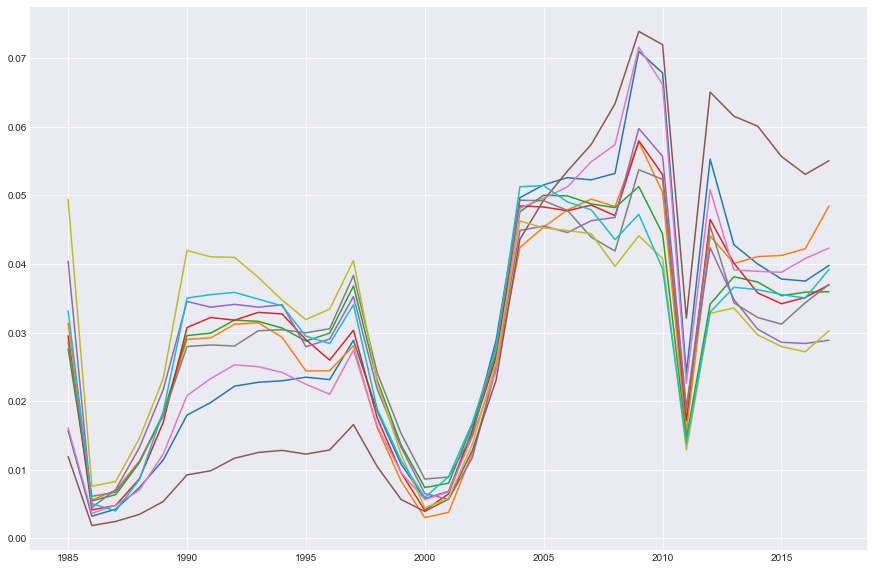

In [473]:
fig, ax = plt.subplots(figsize=(15, 10))
for cat in top_10_categories:
    df = funded_R01_projects[funded_R01_projects.category == cat]
    cats_per_year = df.groupby("FY").count()
    plt.plot(cats_per_year[cats_per_year.index != 2018.0]["grant_num"])#/len(df)) uncomment to make it relative, the correct way of doing it.

In [153]:
funded_R01_projects.category = funded_R01_projects.category.fillna("None")

In [158]:
disease_categories = funded_R01_projects[funded_R01_projects.category.str.contains("isease")]["category"].unique().tolist()

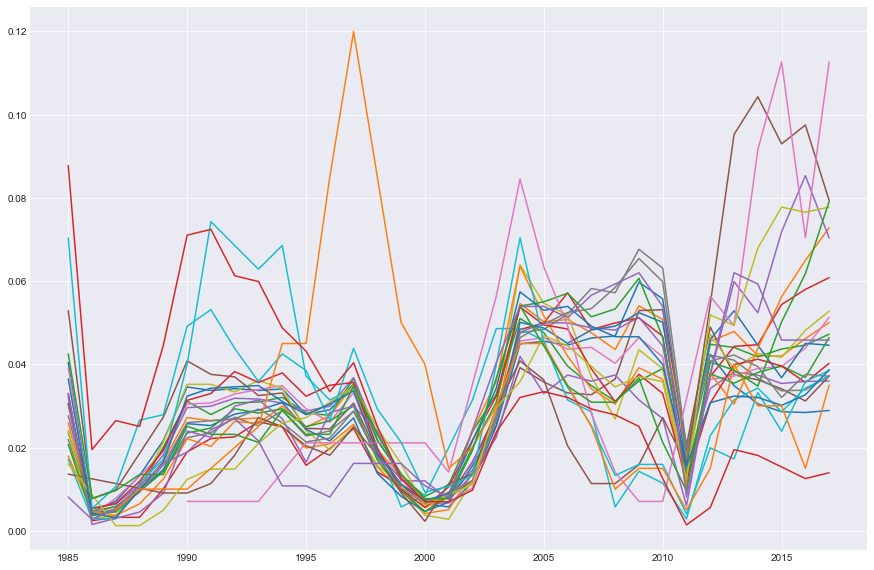

In [474]:
fig, ax = plt.subplots(figsize=(15, 10))
for cat in disease_categories:
    df = funded_R01_projects[funded_R01_projects.category == cat]
    cats_per_year = df.groupby("FY").count()
    plt.plot(cats_per_year[cats_per_year.index != 2018.0]["grant_num"])#/len(df)) uncomment to make relative
#plt.yscale("log")

# Not sure this is going anywhere...
## Try incorporating success rate, see if can get something like amount of money available per number of grants submitted

In [162]:
success_rate_combined = pd.DataFrame()
for root, dirs, files in os.walk("data/original_data/Success_data", topdown=True):
    for file in files:
        df = pd.read_html(os.path.join(root, file), header = 0)[0]
        success_rate_combined = success_rate_combined.append(df)

In [165]:
R01_success_rate = success_rate_combined[success_rate_combined["Activity Code"] == "R01"]

In [213]:
R01_success_rate["success_rate"] = (R01_success_rate["Number of Applications Awarded"]/R01_success_rate["Number of Applications Reviewed"])*100

/Users/maheshrao/anaconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [214]:
R01_success_rate.head()

,Fiscal Year,Award Type,NIH Institute,Activity Code,Number of Applications Reviewed,Number of Applications Awarded,Award Amount,success_rate
1,2001,New,NCI,R01,2581.0,563.0,"$181,546,215",21.813251
10,2001,New,NHLBI,R01,2064.0,589.0,"$207,696,307",28.536822
18,2001,New,NIDCR,R01,297.0,80.0,"$23,772,345",26.936027
24,2001,New,NIDDK,R01,1442.0,308.0,"$97,926,567",21.359223
31,2001,New,NINDS,R01,1362.0,362.0,"$118,674,179",26.578561


# This story mainly stems from the feeling that its getting harder to get grants to do research. When I was going through grad school the stories about PIs who chose to leave the bench because they can't get funding are the ones that stuck in my head. This happened to one of the PIs I know. So why is there this general sense that grant funding is harder to come by? Can we see that grant money is actually decreasing, or that there is less to go around? When there is less to go around, what is the impact on the diversity of research? Are fewer research topics funded? Are certain institutions/PIs favored? Are new grants less likely to be funded?

In [215]:
new_R01_success_rate = R01_success_rate[R01_success_rate["Award Type"] == "New"].sort_values("Fiscal Year")

In [216]:
new_R01_success_rate

,Fiscal Year,Award Type,NIH Institute,Activity Code,Number of Applications Reviewed,Number of Applications Awarded,Award Amount,success_rate
196,1997,New,NIAID,R01,964.123474,299.123444,"$70,202,120",31.025429
94,1997,New,NIDCR,R01,179.000000,40.000000,"$11,806,626",22.346369
86,1997,New,NIDCD,R01,182.000000,35.000000,"$8,588,662",19.230769
212,1997,New,NCI,R01,2065.425293,404.425293,"$98,605,458",19.580727
221,1997,New,NIDA,R01,594.897949,163.897964,"$46,213,679",27.550602
205,1997,New,NIAMS,R01,361.603882,65.603889,"$15,635,478",18.142474
189,1997,New,NIA,R01,470.019836,113.019852,"$27,090,003",24.045762
100,1997,New,NIDDK,R01,1077.490234,265.490204,"$54,380,146",24.639685
107,1997,New,NIEHS,R01,367.718597,75.718597,"$18,111,623",20.591452
119,1997,New,NIGMS,R01,1266.278442,301.278442,"$58,885,341",23.792432


In [217]:
renew_R01_success_rate = R01_success_rate[R01_success_rate["Award Type"] == "Renewal"].sort_values("Fiscal Year")

In [218]:
supplement_R01_success_rate = R01_success_rate[R01_success_rate["Award Type"] == "Supplement"].sort_values("Fiscal Year")

In [177]:
overall_success_rate = pd.read_csv("data/success_rate/T218_Success_Rates_RPG_and_R01_Eq_1_clean.csv")

In [199]:
overall_success_rate["Number of R01 Equivalent Grants Applications Reviewed"] = overall_success_rate["Number of R01 Equivalent Grants Applications Reviewed"].str.replace("\t", "").str.replace(",", "").astype(int)

In [200]:
overall_success_rate["Number of R01 Equivalent Grants Applications Awarded"] = overall_success_rate["Number of R01 Equivalent Grants Applications Awarded"].str.replace("\t", "").str.replace(",", "").astype(int)

In [193]:
overall_success_rate["Success Rate R01 Equivalent Grants"] = overall_success_rate["Success Rate R01 Equivalent Grants"].str.replace("%", "").astype(float)

In [208]:
overall_success_rate.loc[overall_success_rate.FY >= 1985]["Success Rate R01 Equivalent Grants"]

15    32.7
16    32.3
17    35.1
18    31.6
19    27.9
20    24.0
21    28.6
22    29.0
23    23.0
24    24.7
25    26.2
26    27.4
27    30.2
28    30.9
29    32.1
30    32.0
31    31.7
32    30.7
33    30.2
34    25.4
35    22.7
36    20.7
37    23.6
38    23.3
39    22.0
40    22.3
41    18.7
42    18.3
43    17.5
44    18.8
45    18.9
46    20.0
47    19.3
Name: Success Rate R01 Equivalent Grants, dtype: float64

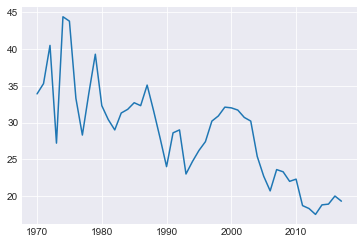

In [203]:
plt.plot(overall_success_rate.FY, overall_success_rate["Success Rate R01 Equivalent Grants"])

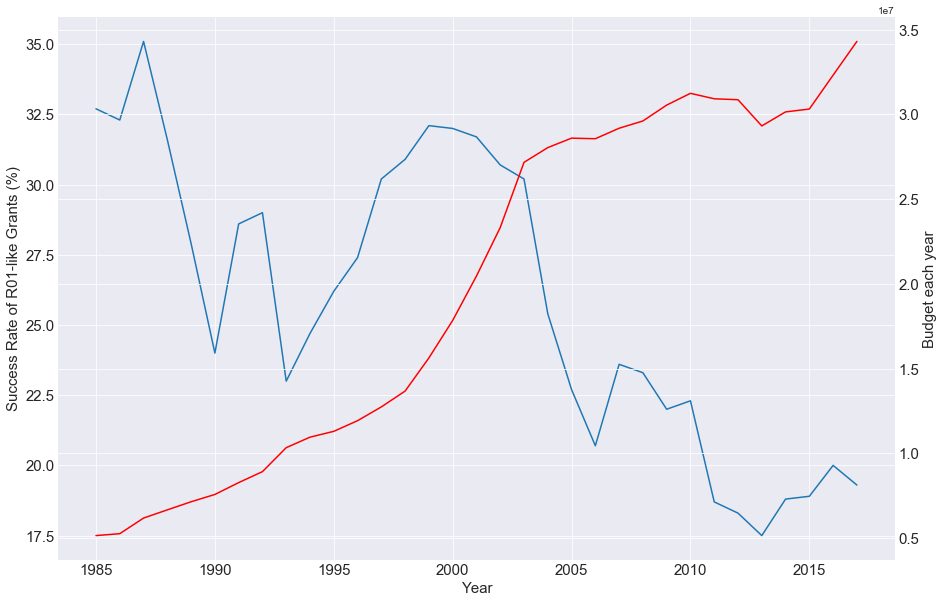

In [210]:
fig, ax = plt.subplots(figsize=(15, 10))
ax2 = ax.twinx()
ax.plot(years[:-1], overall_success_rate.loc[overall_success_rate.FY >= 1985]["Success Rate R01 Equivalent Grants"])
ax2.plot(years[:-1], nih_budget_1985_totals[:-1], color = "red")
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('Success Rate of R01-like Grants (%)', fontsize = 15)
ax2.set_ylabel('Budget each year', fontsize = 15)
ax.tick_params(axis='both', labelsize = 15)
ax2.tick_params(labelsize = 15);

In [220]:
new_R01_success_rate_count = new_R01_success_rate.groupby("Fiscal Year").sum()

In [222]:
new_R01_success_rate_count["success_rate"] = (new_R01_success_rate_count["Number of Applications Awarded"]/new_R01_success_rate_count["Number of Applications Reviewed"])*100

In [223]:
new_R01_success_rate_count

,Number of Applications Reviewed,Number of Applications Awarded,success_rate
Fiscal Year,,,
1997,12609.745245,2857.745159,22.662989
1998,13116.000000,3260.000000,24.855139
1999,16472.000000,4195.000000,25.467460
2000,16827.000000,4364.000000,25.934510
2001,16761.000000,4270.000000,25.475807
2002,16905.000000,4142.000000,24.501627
2003,18733.000000,4521.000000,24.133881
2004,21109.000000,4219.000000,19.986736
2005,21745.000000,3894.000000,17.907565


In [224]:
annual_success_rates = []
for df in [new_R01_success_rate, renew_R01_success_rate, supplement_R01_success_rate]:
    df_sum = df.groupby("Fiscal Year").sum()
    df_sum["success_rate"] = (df_sum["Number of Applications Awarded"]/df_sum["Number of Applications Reviewed"])*100
    annual_success_rates.append(df_sum.success_rate.tolist())

In [225]:
annual_success_rates

[[22.6629888518865,
  24.855138761817628,
  25.467459932005827,
  25.93451001366851,
  25.475806932760577,
  24.501626737651584,
  24.13388138578978,
  19.98673551565683,
  17.907564957461485,
  16.299440130034316,
  19.168926772568774,
  18.983626814952114,
  17.783594251567976,
  17.826265953067104,
  15.096437582859343,
  14.86382270568657,
  14.320106616224582,
  15.449487045731178,
  16.000325375198276,
  17.30247832894184,
  16.7323052007803],
 [46.31531359870936,
  47.498940228910556,
  51.657348242811494,
  49.769769769769766,
  50.77887922314383,
  49.060336300692384,
  48.34651329978433,
  42.14765100671141,
  36.89091480666457,
  33.468346834683466,
  36.14176900357531,
  34.354007186377125,
  34.900307991570756,
  38.0,
  33.47681471336333,
  34.60251046025105,
  31.441819386177965,
  34.63805706201368,
  33.730631704410015,
  35.60830860534125,
  36.829268292682926],
 [54.41176470588235,
  35.39823008849557,
  45.0,
  41.9753086419753,
  36.633663366336634,
  36.7924528301

In [227]:
success_rate_years = new_R01_success_rate_count.index.tolist()

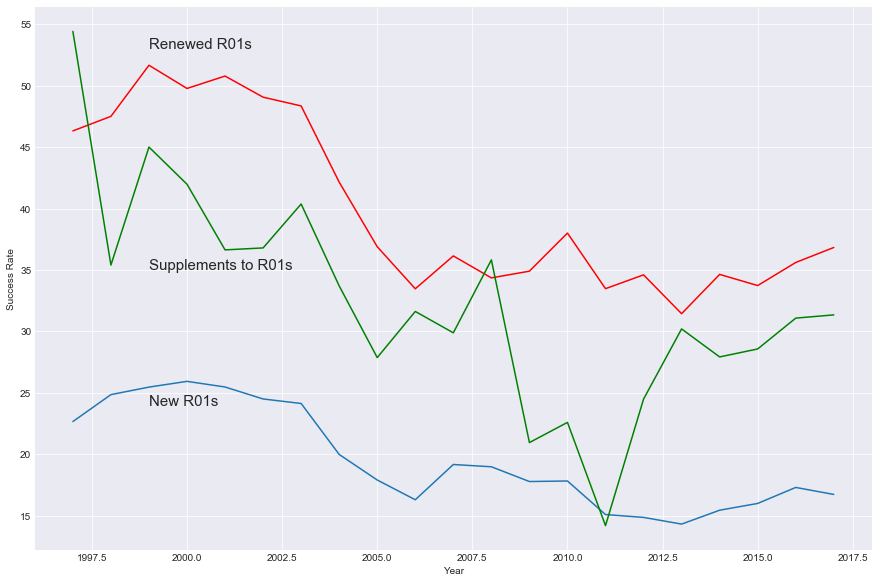

In [231]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(success_rate_years, annual_success_rates[0])
plt.plot(success_rate_years, annual_success_rates[1], color = "red")
plt.plot(success_rate_years, annual_success_rates[2], color = "green")
plt.ylabel("Success Rate")
plt.xlabel("Year")
plt.text(s = "New R01s", x = 1999, y = 24, size = 15)
plt.text(s = "Renewed R01s", x = 1999, y = 53, size = 15)
plt.text(s = "Supplements to R01s", x = 1999, y = 35, size = 15);

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
ax2 = ax.twinx()
ax.plot(years, categories)
ax2.plot(years, nih_budget_1985_totals, color = "red")
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('Number of Topics in Grants each year', fontsize = 15)
ax2.set_ylabel('Budget each year', fontsize = 15)
ax.tick_params(axis='both', labelsize = 15)
ax2.tick_params(labelsize = 15);

In [238]:
rows = {"years":years, "categories":categories, "budget_totals":nih_budget_1985_totals}

In [251]:
regression_df = pd.DataFrame(rows)

In [246]:
sequestration = ["pre"]*19 + ["post"]*15

In [252]:
regression_df["sequestration"] = sequestration

In [281]:
regression_df.drop(33, inplace = True)

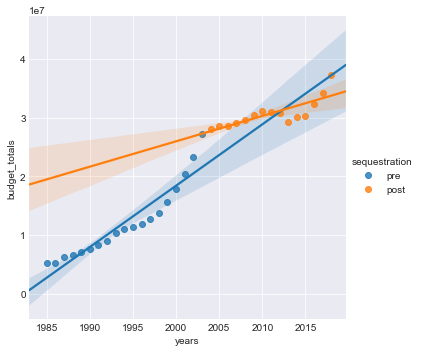

In [263]:
sns.lmplot(x="years", y="budget_totals", hue="sequestration", data=regression_df);

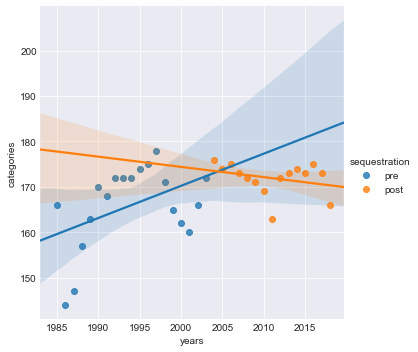

In [264]:
sns.lmplot(x="years", y="categories", hue="sequestration", data=regression_df);

In [278]:
success_rate = overall_success_rate.loc[overall_success_rate.FY >= 1985]["Success Rate R01 Equivalent Grants"].tolist()

In [280]:
len(success_rate)

33

In [282]:
regression_df["success_rate"] = success_rate

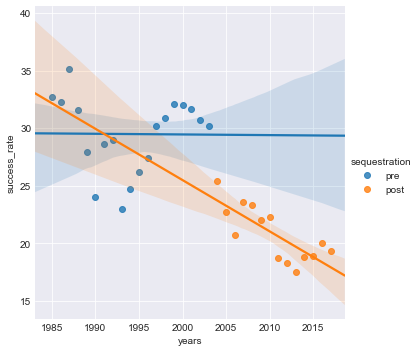

In [285]:
sns.lmplot(x="years", y="success_rate", hue="sequestration", data=regression_df);

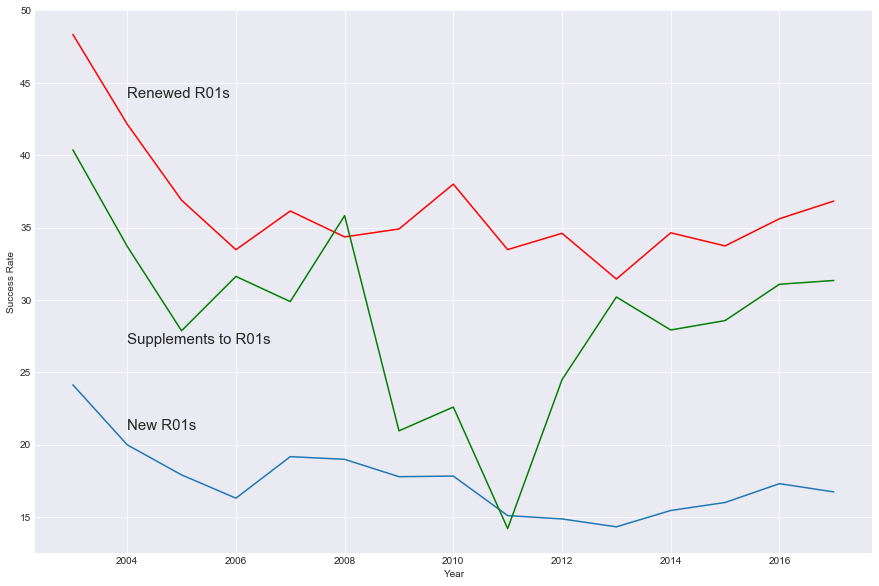

In [290]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(success_rate_years[6:], annual_success_rates[0][6:])
plt.plot(success_rate_years[6:], annual_success_rates[1][6:], color = "red")
plt.plot(success_rate_years[6:], annual_success_rates[2][6:], color = "green")
plt.ylabel("Success Rate")
plt.xlabel("Year")
plt.text(s = "New R01s", x = 2004, y = 21, size = 15)
plt.text(s = "Supplements to R01s", x = 2004, y = 27, size = 15)
plt.text(s = "Renewed R01s", x = 2004, y = 44, size = 15);

In [297]:
success_rate_df_status = pd.DataFrame()
annual_success_rates = []
for status, df in zip(["new", "renew", "supplement"], [new_R01_success_rate, renew_R01_success_rate, supplement_R01_success_rate]):
    df_sum = df.groupby("Fiscal Year").sum()
    df_sum["success_rate"] = (df_sum["Number of Applications Awarded"]/df_sum["Number of Applications Reviewed"])*100
    df_sum["status"] = status
    success_rate_df_status = success_rate_df_status.append(df_sum)
success_rate_df_status.reset_index(inplace = True)

In [298]:
success_rate_df_status

,Fiscal Year,Number of Applications Reviewed,Number of Applications Awarded,success_rate,status
0,1997,12609.745245,2857.745159,22.662989,new
1,1998,13116.000000,3260.000000,24.855139,new
2,1999,16472.000000,4195.000000,25.467460,new
3,2000,16827.000000,4364.000000,25.934510,new
4,2001,16761.000000,4270.000000,25.475807,new
5,2002,16905.000000,4142.000000,24.501627,new
6,2003,18733.000000,4521.000000,24.133881,new
7,2004,21109.000000,4219.000000,19.986736,new
8,2005,21745.000000,3894.000000,17.907565,new
9,2006,22148.000000,3610.000000,16.299440,new


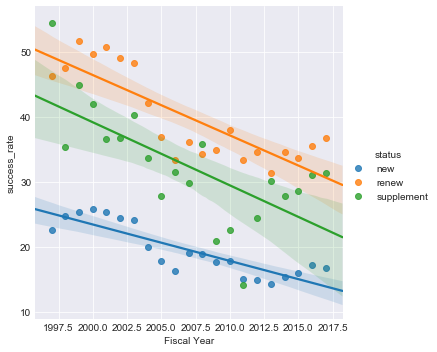

In [305]:
p = sns.lmplot(x="Fiscal Year", y="success_rate", hue="status", data=success_rate_df_status);

In [313]:
#slope, intercept, r_value, p_value, std_err = linregress(x=p.get_lines()[0].get_xdata(),y=p.get_lines()[0].get_ydata())

In [314]:
#dir(p)

In [315]:
categories_represented_per_year = []
for year in np.sort(funded_R01_projects.FY.unique()):
    df_year = funded_R01_projects[funded_R01_projects.FY == year]
    categories_represented = df_year.category.unique().tolist()
    categories_represented_per_year.append(categories_represented)

In [316]:
categories_represented_per_year

[['Neurosciences',
  'Alcoholism, Alcohol Use and Health',
  'Pediatric',
  'Substance Abuse',
  'Liver Disease',
  'Basic Behavioral and Social Science',
  'Chronic Liver Disease and Cirrhosis',
  'Digestive Diseases',
  'Depression',
  'Pregnancy',
  'Infertility',
  'Neurodegenerative',
  'Health Services',
  "Women's Health",
  'Violence Research',
  'Dementia',
  'Genetic Testing',
  'Dietary Supplements',
  'Rural Health',
  'Bioengineering',
  'ALS',
  'Heart Disease',
  'Sleep Research',
  'Genetics',
  'Pain Conditions - Chronic',
  'Comparative Effectiveness Research',
  'Clinical Research',
  'Major Depressive Disorder',
  'Rehabilitation',
  'Heart Disease - Coronary Heart Disease',
  'Epilepsy',
  'Cervical Cancer',
  'Aging',
  'Human Genome',
  'Prostate Cancer',
  'Cerebral Palsy',
  'Osteoporosis',
  'Emphysema',
  'Dental_Oral and Craniofacial Disease',
  'Regenerative Medicine',
  'Multiple Sclerosis',
  'Infectious Diseases',
  'Obesity',
  'Asthma',
  'Down Syndrom

In [337]:
gained_from_previous_year = []
dropped_from_previous_year = []
for y in list(range(len(years)-1)):
    gained_from_previous_year.append(np.setdiff1d(categories_represented_per_year[y+1], categories_represented_per_year[y]).tolist())
    dropped_from_previous_year.append(np.setdiff1d(categories_represented_per_year[y], categories_represented_per_year[y+1]).tolist())

In [339]:
dropped_from_previous_year

[['Acquired Cognitive Impairment',
  'Adolescent Sexual Activity',
  'Aphasia',
  'Ataxia Telangiectasia',
  'Back Pain',
  'Behavioral and Social Science',
  'Cachexia',
  'Congenital Structural Anomalies',
  'Cost Effectiveness Research',
  "Crohn's Disease",
  'Hepatitis - C',
  'Inflammatory Bowel Disease',
  'Interstitial Cystitis',
  'Otitis Media',
  'Perinatal Period - Conditions Originating in Perinatal Period',
  'Prevention',
  'Scleroderma',
  'Smoking and Health',
  'Spinal Muscular Atrophy',
  'Stem Cell Research',
  'Stem Cell Research - Umbilical Cord Blood_ Placenta - Human',
  'Teenage Pregnancy'],
 ['Brain Disorders',
  'Dystonia',
  'Homelessness',
  'Mind and Body',
  'Rare Diseases',
  'Youth Violence'],
 ['Childhood Leukemia', 'None'],
 [],
 [],
 ['Acquired Cognitive Impairment', 'Myotonic Dystrophy', 'Tuberous Sclerosis'],
 ['Injury - Childhood Injuries'],
 ['Ataxia Telangiectasia'],
 ['Polycystic Kidney Disease', 'Spinal Muscular Atrophy', 'Teenage Pregnancy'],

In [342]:
# split df into before and after 2003, 2003 goes with before
before_2003 = funded_R01_projects[funded_R01_projects.FY <= 2003]

after_2003 = funded_R01_projects[funded_R01_projects.FY > 2003]

In [345]:
#print(len(before_2003.category.unique()), len(after_2003.category.unique()))

[cat for cat in before_2003.category.unique() if cat not in after_2003.category.unique()]

# Fetal Alcohol Syndrome is not a topic in after_2003 df

['Fetal Alcohol Syndrome']

In [416]:
before_2003_category_counts = pd.DataFrame(before_2003.category.value_counts()).reset_index()
after_2003_category_counts = after_2003.category.value_counts()
after_2003_category_counts = pd.DataFrame(after_2003_category_counts.append(pd.Series(0, index=["Fetal Alcohol Syndrome"]))).reset_index()


In [417]:
after_2003_category_counts.columns = ["category", "count"]
after_2003_category_counts["label"] = "after"
after_2003_category_counts["norm_counts"] = after_2003_category_counts["count"]/len(after_2003)

In [418]:
before_2003_category_counts.columns = ["category", "count"]
before_2003_category_counts["label"] = "before"
before_2003_category_counts["norm_counts"] = before_2003_category_counts["count"]/len(before_2003)

In [419]:
category_counts_before_after = pd.concat([before_2003_category_counts, after_2003_category_counts])

In [420]:
category_counts_before_after

,category,count,label,norm_counts
0,Genetics,21367,before,0.090174
1,Bioengineering,12887,before,0.054387
2,Infectious Diseases,12826,before,0.054129
3,Pediatric,9897,before,0.041768
4,Digestive Diseases,7294,before,0.030783
5,Pregnancy,6383,before,0.026938
6,Epilepsy,5603,before,0.023646
7,Basic Behavioral and Social Science,5206,before,0.021971
8,Infertility,5145,before,0.021713
9,Liver Disease,4507,before,0.019021


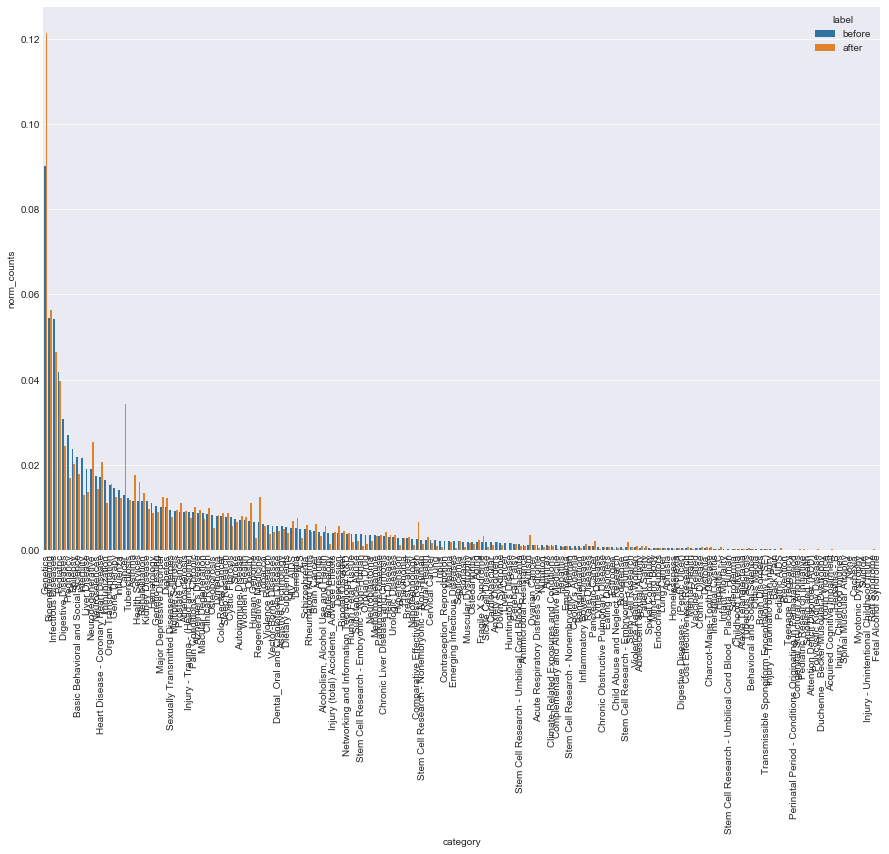

In [425]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x = "category", y = "norm_counts", hue = "label", data = category_counts_before_after)
plt.xticks(rotation='vertical');

In [491]:
category_counts_before_after_wide = before_2003_category_counts[["category", "count", "norm_counts"]].merge(after_2003_category_counts[["category", "count", "norm_counts"]], how = "inner", on = "category", suffixes = ["_before", "_after"])
category_counts_before_after_wide.drop(category_counts_before_after_wide[category_counts_before_after_wide.category.isin(["Fetal Alcohol Syndrome", "Suicide", "Injury - Unintentional Childhood Injury"])].index, inplace = True)

In [492]:
category_counts_before_after_wide["fold_change"] = ((category_counts_before_after_wide["norm_counts_after"]-category_counts_before_after_wide["norm_counts_before"])/category_counts_before_after_wide["count_before"])*10000000
category_counts_before_after_wide["absolute_change"] = abs(category_counts_before_after_wide["fold_change"])

In [496]:
bottom_10_fold_change = category_counts_before_after_wide.sort_values("fold_change").head(5)
top_10_fold_change = category_counts_before_after_wide.sort_values("fold_change").tail(5)
top_bottom_10_fc = bottom_10_fold_change.append(top_10_fold_change)

In [497]:
top_bottom_10_fc

,category,count_before,norm_counts_before,count_after,norm_counts_after,fold_change,absolute_change
86,Contraception_Reproduction,518,0.002186,20,0.000051,-41.215964,41.215964
99,Liver Cancer,411,0.001735,62,0.000158,-38.347639,38.347639
110,Complementary and Alternative Medicine,275,0.001161,92,0.000235,-33.653356,33.653356
88,Emerging Infectious Diseases,516,0.002178,202,0.000516,-32.198580,32.198580
68,Stem Cell Research - Embryonic - Non-Human,899,0.003794,401,0.001025,-30.803836,30.803836
104,Autism,314,0.001325,1359,0.003473,68.399727,68.399727
17,Cancer,3054,0.012889,13452,0.034376,70.359525,70.359525
174,Cachexia,10,0.000042,58,0.000148,106.015926,106.015926
169,Acquired Cognitive Impairment,22,0.000093,157,0.000401,140.166599,140.166599
178,Rett Syndrome,3,0.000013,86,0.000220,690.371882,690.371882


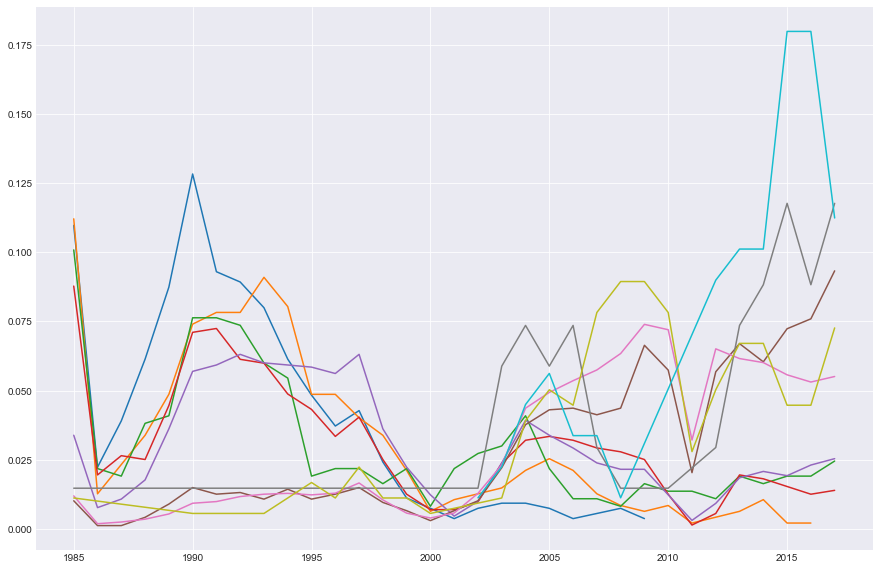

In [498]:
# Graph shows top 5 increased and decreased. Can see things that were high before 2003 were low after and vice versa

fig, ax = plt.subplots(figsize=(15, 10))
for cat in top_bottom_10_fc.category:
    df = funded_R01_projects[funded_R01_projects.category == cat]
    cats_per_year = df.groupby("FY").count()
    plt.plot(cats_per_year[cats_per_year.index != 2018.0]["grant_num"]/len(df))

# This makes me think about clustering, try this maybe, first make sure other things are sorted.

In [502]:
category_counts_before_after_big_changes = category_counts_before_after[category_counts_before_after.category.isin(top_bottom_10_fc.category)]

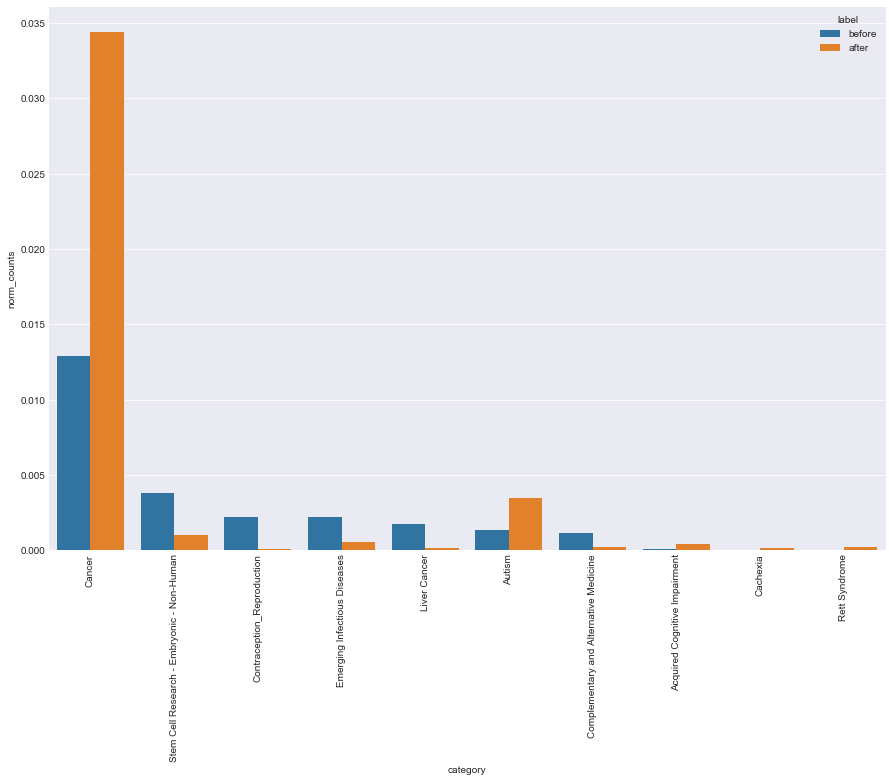

In [503]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x = "category", y = "norm_counts", hue = "label", data = category_counts_before_after_big_changes)
plt.xticks(rotation='vertical');

In [546]:
cat_freq_per_year = []
for cat in funded_R01_projects.category.unique():
    sub_df = funded_R01_projects[funded_R01_projects.category == cat]
    year_freq = []
    for year in funded_R01_projects.FY.unique():
        year_freq.append(len(sub_df[sub_df.FY == year])/len(funded_R01_projects[funded_R01_projects.FY == year]))
    cat_freq_per_year.append(year_freq)

In [547]:
cat_freq_array = np.array(cat_freq_per_year)
cat_freq_df = pd.DataFrame(cat_freq_array)
cat_freq_df.columns = funded_R01_projects.FY.unique()
cat_freq_df.index = funded_R01_projects.category.unique()

In [548]:
cat_freq_df

,2018.0,2017.0,2015.0,2016.0,1998.0,1989.0,1995.0,2009.0,2008.0,2006.0,...,1985.0,1991.0,1990.0,1992.0,1986.0,1987.0,1993.0,1997.0,1996.0,1994.0
Genetics,0.061879,0.080086,0.083713,0.083551,0.077240,0.071926,0.076979,0.082466,0.084510,0.085007,...,0.141510,0.147227,0.151835,0.139769,0.113581,0.109270,0.104329,0.101624,0.100824,0.100491
Bipolar Disorder,0.004057,0.003933,0.002563,0.002780,0.004607,0.005051,0.004963,0.004692,0.004042,0.003813,...,0.004051,0.004694,0.005138,0.004661,0.003776,0.004560,0.004405,0.004916,0.005775,0.007156
Digestive Diseases,0.038853,0.027172,0.034169,0.036462,0.035777,0.033728,0.031976,0.030958,0.030559,0.030770,...,0.029077,0.029521,0.029450,0.026170,0.022578,0.020339,0.019264,0.018799,0.017877,0.017072
Heart Disease - Coronary Heart Disease,0.017998,0.018234,0.020216,0.019457,0.019898,0.019215,0.018159,0.017583,0.017786,0.016378,...,0.019038,0.019471,0.020000,0.020334,0.022462,0.020300,0.020465,0.022102,0.022401,0.025762
Pediatric,0.042852,0.037898,0.034738,0.036135,0.042149,0.045338,0.046131,0.043579,0.045112,0.044625,...,0.042589,0.042439,0.040000,0.043347,0.039260,0.036040,0.034803,0.035081,0.034540,0.034144
Clinical Research,0.009370,0.011441,0.008257,0.008012,0.009214,0.010275,0.009192,0.008791,0.008893,0.009022,...,0.010647,0.009168,0.008807,0.008075,0.010749,0.010903,0.010413,0.009950,0.010226,0.010223
Rehabilitation,0.010970,0.008938,0.007688,0.007031,0.010194,0.011146,0.012294,0.012513,0.012774,0.013371,...,0.015682,0.014430,0.016697,0.015526,0.014178,0.013242,0.013216,0.011405,0.012102,0.011143
Neurodegenerative,0.013313,0.018949,0.019932,0.016678,0.017448,0.017474,0.019005,0.019740,0.019511,0.018795,...,0.029945,0.030151,0.030000,0.026977,0.021807,0.022322,0.022468,0.023204,0.022512,0.023615
Bioengineering,0.062621,0.070075,0.069761,0.064585,0.061459,0.058865,0.057580,0.058843,0.059179,0.054989,...,0.058415,0.055514,0.049908,0.056524,0.053940,0.056895,0.057712,0.058009,0.062275,0.058884
Septicemia,0.001314,0.000715,0.000285,0.001308,0.001470,0.001451,0.002199,0.002319,0.002479,0.002255,...,0.001996,0.001764,0.001927,0.002055,0.002504,0.002379,0.003324,0.003776,0.003237,0.003169


In [549]:
# Next two cells are from here: https://stackoverflow.com/questions/35758612/most-efficient-way-to-construct-similarity-matrix

def similarity_func(u, v):
    return 1/(1+euclidean(u,v))

In [552]:
dists = pdist(cat_freq_df, similarity_func)
DF_euclid = pd.DataFrame(squareform(dists), columns=cat_freq_df.index, index=cat_freq_df.index)

In [553]:
DF_euclid

,Genetics,Bipolar Disorder,Digestive Diseases,Heart Disease - Coronary Heart Disease,Pediatric,Clinical Research,Rehabilitation,Neurodegenerative,Bioengineering,Septicemia,...,Tuberous Sclerosis,Spinal Muscular Atrophy,Prevention,Smoking and Health,Interstitial Cystitis,Youth Violence,Ataxia Telangiectasia,None,Injury - Unintentional Childhood Injury,Fetal Alcohol Syndrome
Genetics,0.000000,0.625443,0.679665,0.659676,0.713930,0.636115,0.643906,0.669449,0.752894,0.620857,...,0.617033,0.616056,0.616188,0.616297,0.616530,0.616093,0.616678,0.616016,0.615941,0.615921
Bipolar Disorder,0.625443,0.000000,0.876912,0.920770,0.827865,0.971927,0.955333,0.904611,0.770203,0.987006,...,0.977601,0.975365,0.975649,0.975826,0.976463,0.975377,0.976686,0.975225,0.975018,0.974976
Digestive Diseases,0.679665,0.876912,0.000000,0.938707,0.928135,0.897791,0.910600,0.946194,0.856707,0.867991,...,0.860893,0.859231,0.859561,0.859725,0.860179,0.859343,0.860339,0.859195,0.859029,0.858988
Heart Disease - Coronary Heart Disease,0.659676,0.920770,0.938707,0.000000,0.888918,0.944707,0.958119,0.971013,0.824003,0.910440,...,0.902317,0.900318,0.900623,0.900756,0.901312,0.900361,0.901545,0.900264,0.900064,0.900024
Pediatric,0.713930,0.827865,0.928135,0.888918,0.000000,0.847197,0.860150,0.902139,0.908552,0.819651,...,0.812986,0.811431,0.811714,0.811817,0.812328,0.811494,0.812451,0.811390,0.811238,0.811208
Clinical Research,0.636115,0.971927,0.897791,0.944707,0.847197,0.000000,0.978483,0.926995,0.787332,0.960532,...,0.951852,0.949647,0.950007,0.950135,0.950733,0.949723,0.950950,0.949608,0.949372,0.949334
Rehabilitation,0.643906,0.955333,0.910600,0.958119,0.860150,0.978483,0.000000,0.943200,0.797165,0.944602,...,0.935696,0.933558,0.933882,0.934045,0.934692,0.933618,0.934866,0.933470,0.933281,0.933242
Neurodegenerative,0.669449,0.904611,0.946194,0.971013,0.902139,0.926995,0.943200,0.000000,0.833716,0.894850,...,0.886976,0.884977,0.885256,0.885454,0.885949,0.885045,0.886221,0.884902,0.884734,0.884697
Bioengineering,0.752894,0.770203,0.856707,0.824003,0.908552,0.787332,0.797165,0.833716,0.000000,0.762994,...,0.757436,0.756078,0.756328,0.756389,0.756793,0.756133,0.756905,0.756075,0.755916,0.755891
Septicemia,0.620857,0.987006,0.867991,0.910440,0.819651,0.960532,0.944602,0.894850,0.762994,0.000000,...,0.988968,0.986775,0.986929,0.987163,0.987965,0.986801,0.988018,0.986535,0.986405,0.986345


In [564]:
ac = AgglomerativeClustering(n_clusters = 50)
out_of_box_ac_predict = ac.fit_predict(DF_euclid)

/Users/maheshrao/anaconda3/envs/capstone/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [568]:
Counter(out_of_box_ac_predict)

Counter({31: 1,
         6: 6,
         26: 5,
         41: 3,
         27: 1,
         15: 18,
         40: 11,
         48: 2,
         3: 6,
         2: 12,
         12: 10,
         21: 6,
         7: 7,
         32: 2,
         17: 8,
         28: 2,
         4: 6,
         47: 1,
         16: 2,
         0: 12,
         10: 2,
         13: 4,
         1: 7,
         11: 4,
         36: 1,
         14: 3,
         19: 3,
         18: 2,
         9: 3,
         20: 2,
         43: 1,
         23: 2,
         5: 4,
         42: 1,
         44: 1,
         8: 4,
         29: 2,
         49: 1,
         24: 1,
         45: 1,
         39: 1,
         38: 1,
         25: 1,
         46: 1,
         35: 1,
         30: 1,
         33: 1,
         34: 1,
         37: 1,
         22: 1})

In [575]:
cluster_15 = [ind for ind, val in enumerate(out_of_box_ac_predict) if val == 15]
cluster_2 = [ind for ind, val in enumerate(out_of_box_ac_predict) if val == 2]

In [571]:
DF_euclid.iloc[cluster_15].index

Index(['Clinical Research', 'Sexually Transmitted Diseases_Herpes', 'Dementia',
       'Autoimmune Disease', 'Obesity', 'Cystic Fibrosis', 'Atherosclerosis',
       'Women's Health', 'Macular Degeneration', 'Colo-Rectal Cancer',
       'Brain Cancer', 'Pain Conditions - Chronic', 'Lymphoma',
       'Prostate Cancer', 'Injury - Trauma - (Head and Spine)',
       'Alzheimer's Disease', 'Sleep Research', 'Osteoporosis'],
      dtype='object')

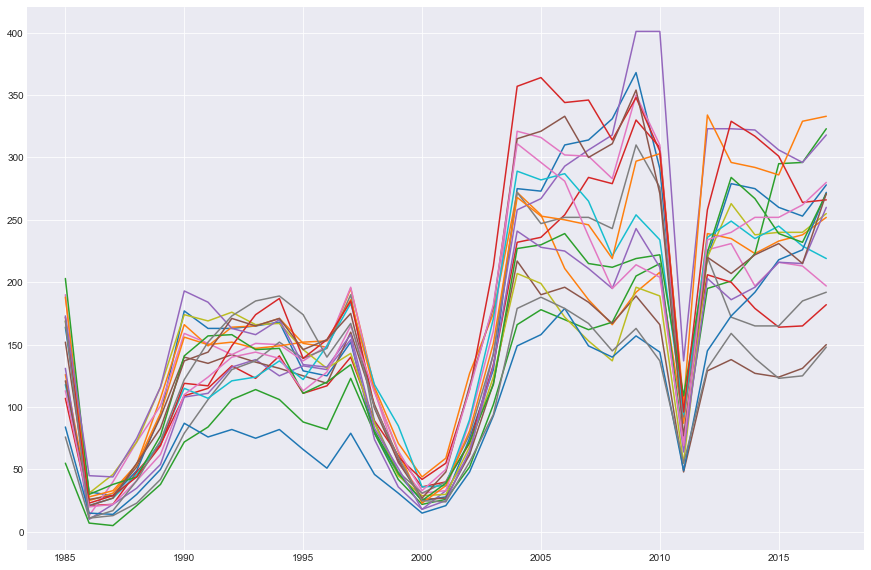

In [573]:
fig, ax = plt.subplots(figsize=(15, 10))
for cat in DF_euclid.iloc[cluster_15].index:
    df = funded_R01_projects[funded_R01_projects.category == cat]
    cats_per_year = df.groupby("FY").count()
    plt.plot(cats_per_year[cats_per_year.index != 2018.0]["grant_num"])

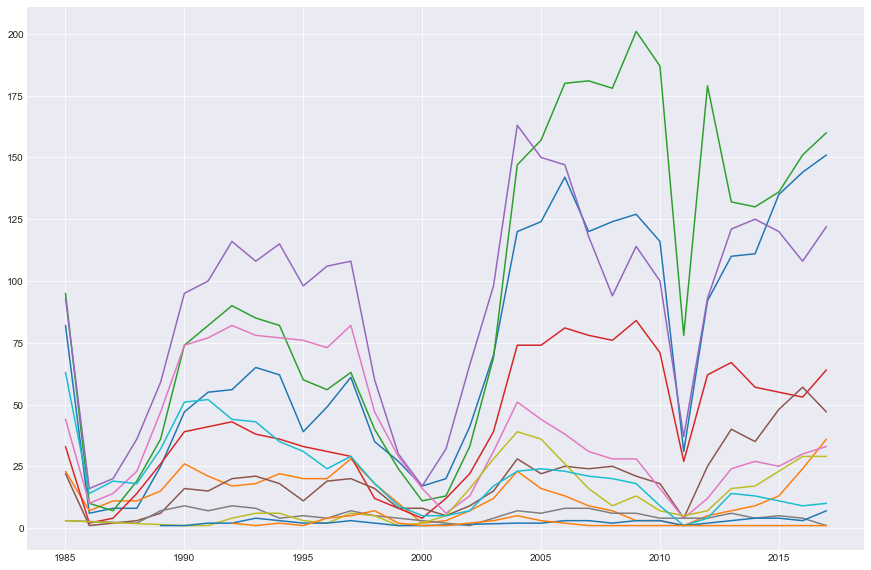

In [576]:
fig, ax = plt.subplots(figsize=(15, 10))
for cat in DF_euclid.iloc[cluster_2].index:
    df = funded_R01_projects[funded_R01_projects.category == cat]
    cats_per_year = df.groupby("FY").count()
    plt.plot(cats_per_year[cats_per_year.index != 2018.0]["grant_num"])

In [554]:
# This is close but something needs to be tweaked...used function found on stack so shelve this for now.

# diff_mat = []
# for i in list(range(len(cat_freq_array))):
#     diffs = []
#     for comp in list(range(len(cat_freq_array))):
#         _sum = 0
#         for j in list(range(len(cat_freq_array[0]))):
#             diff = (cat_freq_array[i][j] - cat_freq_array[comp][j])**2
#             _sum = _sum + diff
#         diffs.append(_sum)
#     diff_mat.append(diffs)
        
#     #print(cat_freq_array[i][0])
# #cat_freq_array[179][33]

In [582]:
DF_euclid.index == "Cancer"

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [592]:
[ind for ind, cat in enumerate(DF_euclid.index) if cat == "Cancer"][0]

43

In [588]:
out_of_box_ac_predict[43]

26

In [589]:
cluster_26 = [ind for ind, val in enumerate(out_of_box_ac_predict) if val == 26]

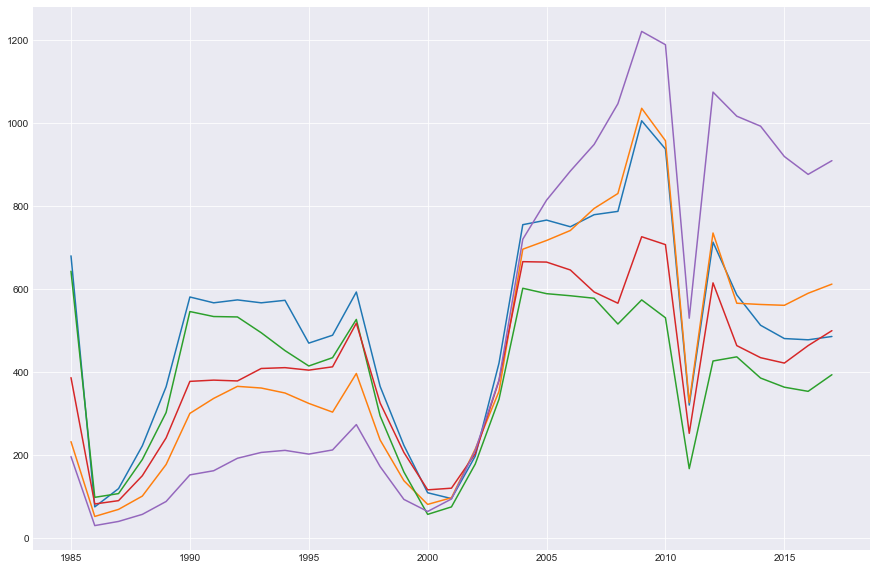

In [590]:
fig, ax = plt.subplots(figsize=(15, 10))
for cat in DF_euclid.iloc[cluster_26].index:
    df = funded_R01_projects[funded_R01_projects.category == cat]
    cats_per_year = df.groupby("FY").count()
    plt.plot(cats_per_year[cats_per_year.index != 2018.0]["grant_num"])

In [591]:
DF_euclid.iloc[cluster_26].index

Index(['Digestive Diseases', 'Neurodegenerative', 'Pregnancy', 'Epilepsy',
       'Cancer'],
      dtype='object')

Index(['Autism', 'Biotechnology', 'Antimicrobial Resistance', 'Hepatitis',
       'Dental_Oral and Craniofacial Disease', 'Pediatric AIDS',
       'Perinatal Period - Conditions Originating in Perinatal Period'],
      dtype='object')

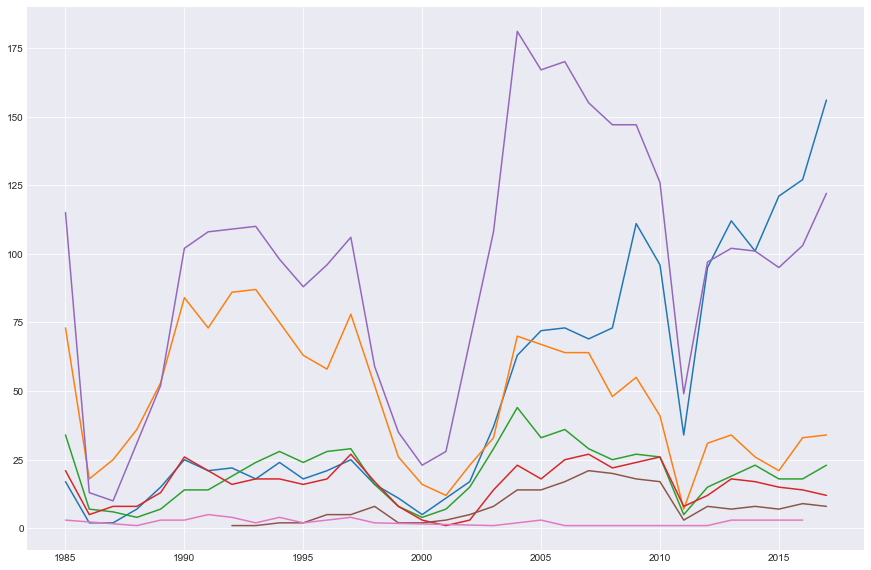

In [593]:
autism_index = [ind for ind, cat in enumerate(DF_euclid.index) if cat == "Autism"][0]

autism_cluster_number = out_of_box_ac_predict[autism_index]

autism_cluster = [ind for ind, val in enumerate(out_of_box_ac_predict) if val == autism_cluster_number]

fig, ax = plt.subplots(figsize=(15, 10))
for cat in DF_euclid.iloc[autism_cluster].index:
    df = funded_R01_projects[funded_R01_projects.category == cat]
    cats_per_year = df.groupby("FY").count()
    plt.plot(cats_per_year[cats_per_year.index != 2018.0]["grant_num"])
    
DF_euclid.iloc[autism_cluster].index

In [701]:
# try using scipy, looks like it can do unsupervised

y = pdist(cat_freq_df, 'euclidean')

z = linkage(y, method='ward', metric='euclidean')

fclust = fcluster(z, t = 1.11, criterion = 'inconsistent')
# Value of t was determined by testing a range. See below.

In [702]:
fclust

array([ 1, 22, 34, 35,  1, 30, 32, 35,  1, 13, 28, 22, 18, 29,  1, 31, 17,
       29, 27, 24, 27, 14, 23, 27, 36, 36, 15, 23, 27, 20, 33, 29, 24, 34,
       17, 27, 23, 27, 34, 32, 25, 24, 27, 37, 16, 31, 10, 23, 26, 28, 26,
       25, 30, 23, 21, 28, 16, 24, 36, 23, 30, 30, 21, 23, 11, 28, 12, 18,
       28, 17, 12, 20,  6, 30, 22, 17, 28, 19, 24, 30, 14, 15, 12, 28, 24,
        5, 17,  4, 11, 19, 10,  5, 19, 21, 17, 18, 10, 19, 19, 20,  4, 18,
       20, 11, 20, 17, 14, 17, 17, 26, 11, 26, 19, 10, 18,  3, 17, 17, 18,
        8, 11, 24, 11, 11,  8, 17, 13,  5, 10,  2, 11, 17, 24, 15, 17, 11,
       20, 18, 17, 17, 11,  3,  4, 11,  9,  4,  2, 18, 18,  7, 18, 17,  2,
       17, 11,  2,  2, 11, 10,  6, 11, 11, 11, 11,  2,  7,  2, 11,  2,  4,
       11,  2,  2,  3, 11,  2, 11,  2,  2,  2], dtype=int32)

In [705]:
#Counter(fclust)
assignments = []
clusters = set(fclust)
for clust in clusters:
    inds_in_cat = [ind for ind, val in enumerate(fclust) if val == clust]
    topics_in_cat = DF_euclid.iloc[inds_in_cat].index.tolist()
    assignments.append(topics_in_cat)

In [708]:
assignments

[['Genetics', 'Pediatric', 'Bioengineering', 'Infectious Diseases'],
 ['Myotonic Dystrophy',
  'Teenage Pregnancy',
  'Duchenne_ Becker Muscular Dystrophy',
  'Hepatitis - B',
  'Perinatal Period - Conditions Originating in Perinatal Period',
  'Attention Deficit Disorder (ADD)',
  'Suicide',
  'Injury - Childhood Injuries',
  'Spinal Muscular Atrophy',
  'Prevention',
  'Youth Violence',
  'None',
  'Injury - Unintentional Childhood Injury',
  'Fetal Alcohol Syndrome'],
 ['Stem Cell Research - Umbilical Cord Blood_ Placenta - Human',
  'Infant Mortality',
  'Smoking and Health'],
 ['Acquired Cognitive Impairment',
  'Brain Disorders',
  'Pediatric AIDS',
  'Behavioral and Social Science',
  'Transmissible Spongiform Encephalopathy (TSE)'],
 ['Cachexia', 'Polycystic Kidney Disease', 'Rett Syndrome'],
 ['Childhood Leukemia', 'Pediatric Research Initiative'],
 ['Back Pain', 'Injury - Traumatic brain injury'],
 ['Otitis Media', 'Congenital Structural Anomalies'],
 ['Scleroderma'],
 ['Viol

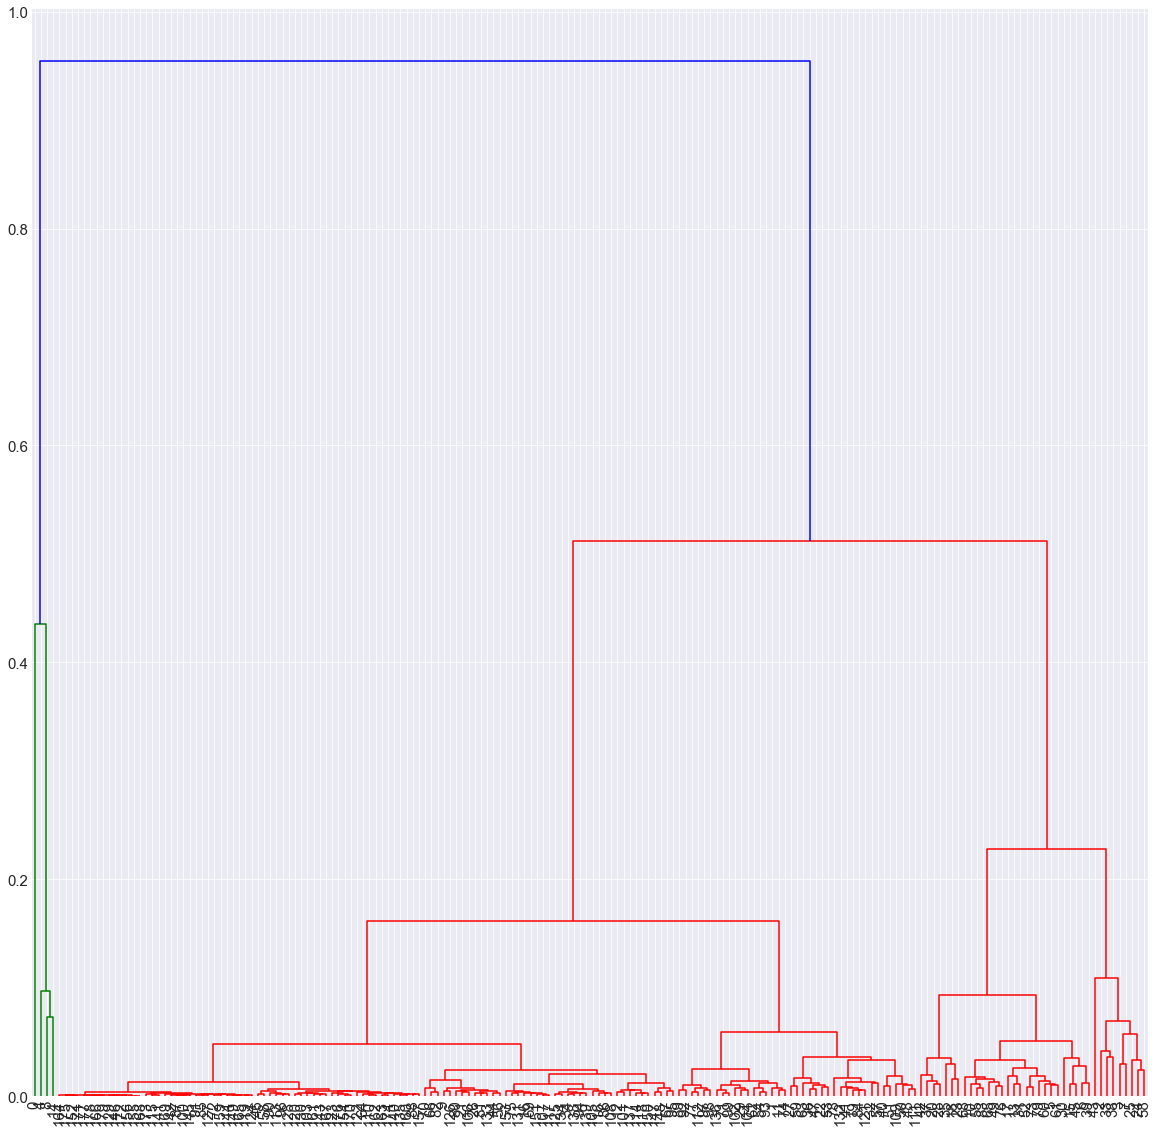

In [649]:
fig, ax = plt.subplots(figsize=(20, 20))
dendrogram(z)
ax.tick_params(axis='both', labelsize = 15);

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5],
  [65.0, 65.0, 75.0, 75.0],
  [55.0, 55.0, 70.0, 70.0],
  [45.0, 45.0, 62.5, 62.5],
  [105.0, 105.0, 115.0, 115.0],
  [95.0, 95.0, 110.0, 110.0],
  [85.0, 85.0, 102.5, 102.5],
  [125.0, 125.0, 135.0, 135.0],
  [165.0, 165.0, 175.0, 175.0],
  [155.0, 155.0, 170.0, 170.0],
  [145.0, 145.0, 162.5, 162.5],
  [130.0, 130.0, 153.75, 153.75],
  [93.75, 93.75, 141.875, 141.875],
  [53.75, 53.75, 117.8125, 117.8125],
  [195.0, 195.0, 205.0, 205.0],
  [185.0, 185.0, 200.0, 200.0],
  [245.0, 245.0, 255.0, 255.0],
  [235.0, 235.0, 250.0, 250.0],
  [225.0, 225.0, 242.5, 242.5],
  [215.0, 215.0, 233.75, 233.75],
  [275.0, 275.0, 285.0, 285.0],
  [265.0, 265.0, 280.0, 280.0],
  [295.0, 295.0, 305.0, 305.0],
  [325.0, 325.0, 335.0, 335.0],
  [345.0, 345.0, 355.0, 355.0],
  [330.0, 330.0, 350.0, 350.0],
  [315.0, 315.0, 340.0, 340.0],
  [300.0, 300.0, 327.5, 327.5],
  [272.5, 272.5, 313.75, 313.75],
  [224.375, 

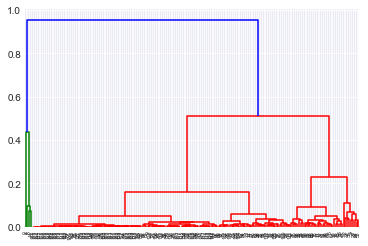

In [629]:
dendrogram(z)

In [652]:
#f_clusts = []
#for t in [1, 1.1, 1.2, 1.3, 1.4, 1.5]:
#    fclusts.append(fcluster(z, t = t, criterion = 'inconsistent'))
    
f_clusts = [fcluster(z, t = t, criterion = 'inconsistent') for t in [1, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15]]

In [655]:
f_clusts[0]

array([ 1, 36, 51, 52,  1, 47, 49, 52,  1, 19, 43, 36, 28, 46,  1, 48, 24,
       46, 42, 39, 42, 20, 38, 42, 53, 53, 21, 37, 42, 34, 50, 46, 39, 51,
       26, 42, 38, 42, 51, 49, 40, 39, 42, 54, 22, 48, 13, 38, 41, 44, 41,
       40, 47, 38, 35, 43, 22, 39, 53, 37, 47, 47, 35, 38, 17, 44, 18, 30,
       45, 24, 18, 33,  9, 47, 36, 23, 44, 32, 39, 47, 20, 21, 18, 43, 39,
        8, 27,  7, 17, 31, 14,  8, 31, 35, 26, 30, 14, 32, 32, 33,  7, 28,
       34, 16, 34, 27, 20, 24, 27, 41, 17, 41, 32, 14, 28,  6, 27, 24, 28,
       11, 15, 39, 17, 17, 11, 26, 19,  8, 14,  4, 15, 23, 39, 21, 26, 17,
       33, 28, 26, 26, 17,  6,  7, 16, 12,  7,  4, 29, 29, 10, 28, 24,  2,
       25, 17,  5,  5, 17, 13,  9, 17, 16, 17, 17,  2, 10,  3, 16,  5,  7,
       17,  2,  5,  6, 17,  2, 17,  3,  3,  3], dtype=int32)

In [659]:
f_clust_assignments = []
for t in f_clusts:
    assignments = []
    clusters = set(t)
    for clust in clusters:
        inds_in_cat = [ind for ind, val in enumerate(t) if val == clust]
        topics_in_cat = DF_euclid.iloc[inds_in_cat].index.tolist()
        assignments.append(topics_in_cat)
    f_clust_assignments.append(assignments)

In [699]:
# Looks like grouping is actually pretty good. Maybe too many clusters with first one. Last one is too few.
len(f_clust_assignments[2])

37

In [684]:
# check against before_after 2003 measurements

category_counts_before_after_wide.sort_values("fold_change", ascending = False)
#category_counts_before_after_wide[category_counts_before_after_wide.category == "Lyme Disease"]

,category,count_before,norm_counts_before,count_after,norm_counts_after,fold_change,absolute_change
178,Rett Syndrome,3,0.000013,86,0.000220,690.371882,690.371882
169,Acquired Cognitive Impairment,22,0.000093,157,0.000401,140.166599,140.166599
174,Cachexia,10,0.000042,58,0.000148,106.015926,106.015926
17,Cancer,3054,0.012889,13452,0.034376,70.359525,70.359525
104,Autism,314,0.001325,1359,0.003473,68.399727,68.399727
125,Stem Cell Research - Embryonic - Human,171,0.000722,716,0.001830,64.799269,64.799269
151,Tuberous Sclerosis,60,0.000253,245,0.000626,62.146638,62.146638
80,Comparative Effectiveness Research,640,0.002701,2605,0.006657,61.813891,61.813891
118,Pancreatic Cancer,213,0.000899,859,0.002195,60.856894,60.856894
158,Pediatric AIDS,44,0.000186,173,0.000442,58.274679,58.274679


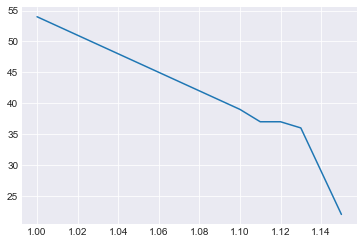

In [700]:
# See if can make an elbow graph
plt.plot([1, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15], [len(f_clust) for f_clust in f_clust_assignments]);
# 1.1 is the value for t, I'm calling it.

category_counts_before_after = pd.concat([before_2003_category_counts, after_2003_category_counts], axis = 1).reset_index()
category_counts_before_after.columns = ["category", "before", "after"]

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(15, 10))
axes[0].barh(category_counts_before_after.category, category_counts_before_after.before, align='center', color='gray')
axes[0].set(title='2003 and Earlier')
axes[1].barh(category_counts_before_after.category, category_counts_before_after.after, align='center', color='gray')
axes[1].set(title='After 2003')

axes[0].invert_xaxis()
#axes[0].set(yticklabels=category_counts_before_after.category)
#axes[0].yaxis.tick_right()

for ax in axes.flat:
    ax.margins(0.03)
    ax.grid(True)

fig.tight_layout()
fig.subplots_adjust(wspace=0.09)
plt.show()

states = ["AK", "TX", "CA", "MT", "NM", "AZ", "NV", "CO", "OR", "WY", "MI",
          "MN", "UT", "ID", "KS", "NE", "SD", "WA", "ND", "OK"]
staff = np.array([20, 30, 40, 10, 15, 35, 18, 25, 22, 7, 12, 22, 3, 4, 5, 8,
                  14, 28, 24, 32])
sales = staff * (20 + 10 * np.random.random(staff.size))

# Sort by number of sales staff
idx = staff.argsort()
states, staff, sales = [np.take(x, idx) for x in [states, staff, sales]]

y = np.arange(sales.size)

fig, axes = plt.subplots(ncols=2, sharey=True)
axes[0].barh(y, staff, align='center', color='gray', zorder=10)
axes[0].set(title='Number of sales staff')
axes[1].barh(y, sales, align='center', color='gray', zorder=10)
axes[1].set(title='Sales (x $1000)')

axes[0].invert_xaxis()
axes[0].set(yticks=y, yticklabels=states)
axes[0].yaxis.tick_right()

for ax in axes.flat:
    ax.margins(0.03)
    ax.grid(True)

fig.tight_layout()
fig.subplots_adjust(wspace=0.09)
plt.show()